# Phân tích tương quan giữa 2 kênh tín hiệu sinh học

### BS. Lê Ngọc Khả Nhi


# Khởi hành

Thân chào các bạn đồng nghiệp, đây là bài thực hành thứ 4 trong dự án Phân tích tín hiệu sinh học. Trong bài này, Nhi sẽ sử dụng một số phương pháp thống kê trên dữ liệu chuỗi để giải quyết một nghiên cứu với mục tiêu là khảo sát sự tương quan giữa 3 kênh tín hiệu hô hấp (Th_Flow, Tx_RIP, Abd_RIP) và tín hiệu Áp suất thực quản (OEP) trong giấc ngủ, từ đó xác định tín hiệu nào là hiệu quả nhất cho phép phát hiện những biến cố ngưng thở khi ngủ do tắc nghẽn.

Bài thực hành này kế thừa kết quả của bài thứ 2, như các bạn còn nhớ, chúng ta đã tạo ra 1 folder có tên là D_Respiratory trong thư mục hiện hành, bên trong có file DB_Respiratory.pickle chứa thông tin về 5 chuỗi dữ liệu của Flow_th, Abd_RIP, Tx_RIP, OEP và SpO2 lấy mẫu ở tần số 10Hz, và thông tin về các biến cố hô hấp.

Các bạn có thể đi tắt bằng cách tải file pickle này từ github của dự án:
https://github.com/taile2007/Biosignal-analysis/blob/master/Data%20wrangling-01-Importation/D_Respiratory.rar


# Mục tiêu và kế hoạch phân tích

Bối cảnh của nghiên cứu này như sau: Biến cố gắng sức hô hấp do tắc nghẽn của bệnh nhân có thể được ghi nhận trong giấc ngủ bằng nhiều loại cảm biến, thông dụng nhất gồm có: lưu lượng thông khí qua mũi, đo bằng cảm biến nhiệt độ (Thermistor nasal flux, kênh Th_Flow), áp suất hô hấp đo ở ngực (Abd_RIP) và bụng (Abd_RIP), tuy nhiên kỹ thuật chính xác nhất là áp suất thực quản (kênh OEP). Câu hỏi đặt ra là: trong 3 kênh Abd_RIP, Th_Flow và Tx_RIP, kênh nào có mức độ tương quan cao nhất với tín hiệu OEP ? 

Câu hỏi này đặt ra 1 bài toán phân tích tương quan giữa 2 chuỗi dữ liệu. Đối tượng của phân tích là những đoạn tín hiệu ngắn (10 giây, 100 đơn vị lấy mẫu). Tuy nhiên ta không thể áp dụng hệ số tương quan theo Pearson trong thống kê quy ước cho toàn bộ chuỗi dữ liệu. Trong bài, Nhi sẽ thực hiện 3 kỹ thuật gồm:

+ Phân tích tương quan trên cửa sổ trượt (Rolling window correlation)

+ Tương quan chuỗi có độ trễ (Lag Cross-correlarion)

+ Đo lường mức độ tương đồng giữa 2 chuỗi bằng kỹ thuật quy hoạch động (dynamic time wraping, DTW)

Trong đó, 2 kỹ thuật đầu tiên chỉ có tính chất mô tả và thăm dò, còn kỹ thuật DTW được dùng để giải quyết trực tiếp câu hỏi nghiên cứu. 

Code thực hành cho bài 4 này nằm trong module association_analysis có thể tải tại đây:

https://github.com/taile2007/Biosignal-analysis/tree/master/Data%20wrangling-01-Importation/module1

# Triển khai:

## Chuẩn bị dữ liệu

Trước hết, Nhi import toàn bộ nội dung module association_analysis, và dùng class Assoc_experiment để khởi tạo một cơ sở dữ liệu cho thí nghiệm : pat_db, sau đó dùng method get_exp_data để chuẩn bị 2 dataframes chính sẽ được dùng trong suốt quy trình, đó là: 

In [1]:
from module1.association_analysis import *

In [2]:
pat_db = Assoc_experiment(patient_id = 'Respiratory')

pat_db

comb_df, sampl_df = pat_db.get_exp_data()

Lọc tín hiệu sử dụng dc_filter 0.1-1.5, fs = 5


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


1) sampl_df chứa danh sách N đoạn tín hiệu dài 10s (100 đơn vị), cho 2 loại biến cố Obstructive và Central

In [3]:
comb_df

,t,ID,Tx_RIP,Th_Flow,Abd_RIP,OEP
0,0,0,0.502887,0.761755,0.526321,0.461964
1,1,0,0.546407,0.809667,0.518089,0.471378
2,2,0,0.595602,0.850307,0.511661,0.477225
3,3,0,0.647294,0.882126,0.508014,0.473095
4,4,0,0.697564,0.902668,0.509874,0.471662
...,...,...,...,...,...,...
10295,95,102,0.535467,0.551145,0.876767,0.442294
10296,96,102,0.516784,0.534907,0.875126,0.419821
10297,97,102,0.492230,0.512754,0.862750,0.437648
10298,98,102,0.463663,0.486579,0.840972,0.460711


2) comb_df gồm (N x 100) dòng x 4 kênh, tương ứng với N đoạn tín hiệu độ dài 100 xếp chồng lên nhau (bảng dọc). Mỗi đoạn đã được xử lý bằng Minmax scaler và decomposistion (chỉ giữ lại khuynh hướng, khử nhiễu).

In [4]:
sampl_df

,start,end,Hypno_score,Hypno_lab,Resp_score,Resp_lab
0,17150,17250,100.0,2.0,91.0,Cent
1,18200,18300,100.0,2.0,100.0,Obs
2,18250,18350,100.0,2.0,100.0,Obs
3,18300,18400,100.0,2.0,100.0,Obs
4,18350,18450,100.0,2.0,100.0,Obs
...,...,...,...,...,...,...
98,246150,246250,100.0,2.0,100.0,Cent
99,246400,246500,100.0,2.0,100.0,Cent
100,248600,248700,100.0,2.0,96.0,Obs
101,248650,248750,100.0,2.0,100.0,Obs


Ta có 67 đoạn thuộc loại Ngưng/giảm thở trung ương (Central) và 36 đoạn thuộc loại Ngưng giảm thở do tắc nghẽn (Obstructive). Mục tiêu nghiên cứu chỉ nhắm vào loại Obs

In [5]:
sampl_df['Resp_lab'].value_counts()

Cent    67
Obs     36
Name: Resp_lab, dtype: int64

## Rolling window correlation

Trong kỹ thuật này, ta dùng một cửa sổ với độ dài W = 25 mẫu, và di chuyển cửa sổ này dọc theo 2 chuỗi (n=100 x 2) cần phân tích tương quan, ở mỗi vị trí cửa sổ này đi qua, ta tính hệ số tương quan r theo Pearson và giá trị p_value giữa 1 cặp 2 chuỗi tín hiệu (mỗi chuỗi n=25), như vậy kết quả sẽ cho ra 2 arrays gồm 75 giá trị r và 75 giá trị p.

Quy trình này thực hiện bằng hàm rolling_corr(), thí dụ ta bắt cặp OEP và Abd_RIP, cho mẫu số 0, 3, 20 và 47. Kết quả được biểu diễn trực quan như sau:

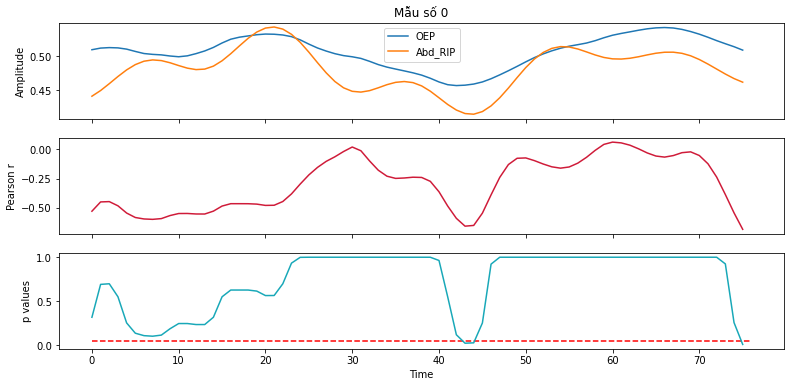

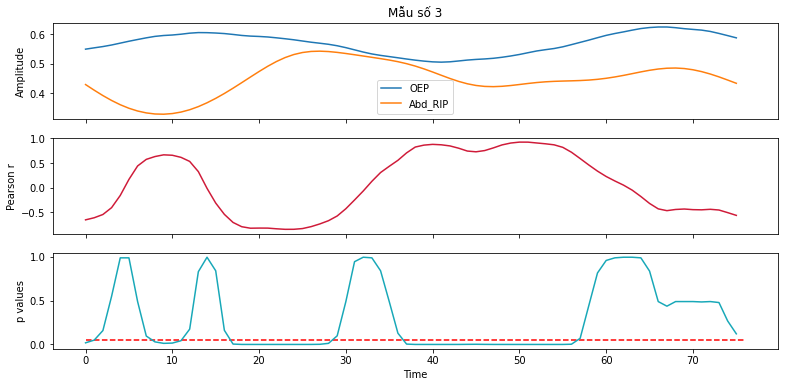

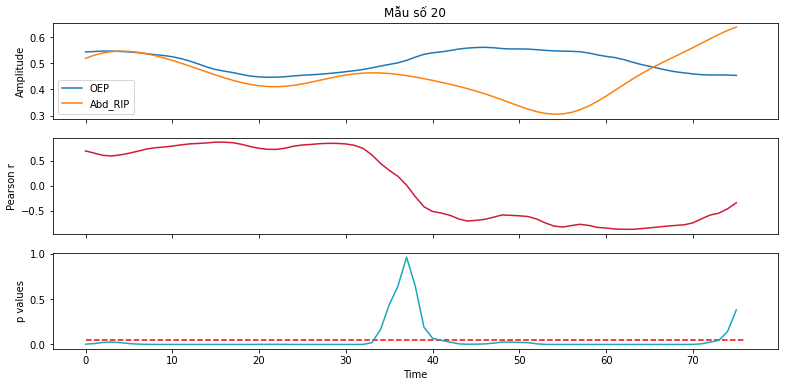

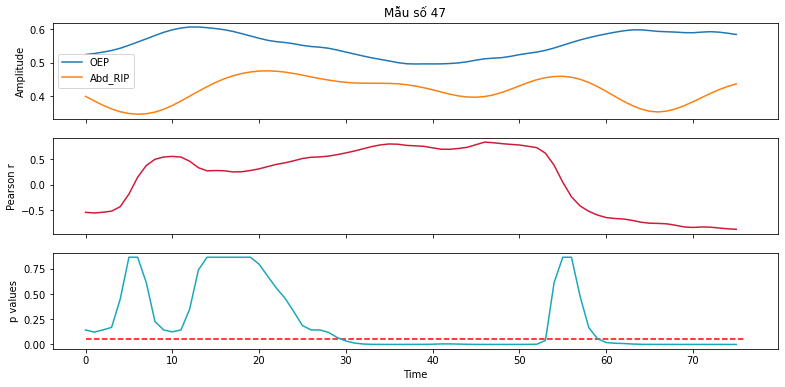

In [6]:
for s_idx in [0,3,20,47]:
    _,_ = rolling_corr(comb_df, sample_idx = s_idx, targets = ['OEP','Abd_RIP'], W = 25, plot = True, adjust = True)

Hàm multiple_rolling_corr sẽ thi hành quy trình rolling window correlation cho hàng loạt chuỗi tín hiệu, và ghép kết quả lại thành một heatmap như sau:

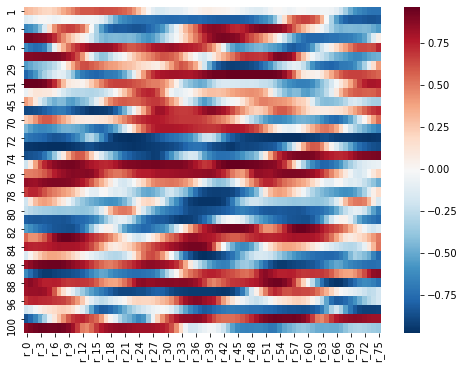

In [7]:
_ = multiple_rolling_corr(comb_df, 
                                     sampl_df, 
                                     targets = ['OEP','Abd_RIP'], 
                                     evt_type = 'Obs',
                                     W = 25, 
                                     plot = True)

## Tương quan chuỗi có độ trễ

Hàm lag_cross_corr sẽ thực hiện một phân tích tương quan giữa 2 chuỗi tín hiệu (n=100) với hàng loạt độ trễ khác nhau, thí dụ từ -50 đến +50, và tự động xác định vị trí của đỉnh đồng bộ (bằng hàm argmax), nơi hệ số tương quan r đạt giá trị cao nhất.

Tương tự như trên, ta thăm dò 4 chuỗi 0,3,20,47 cho cặp OEP và Abd_RIP:

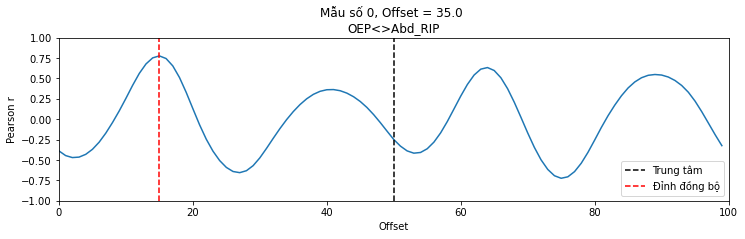

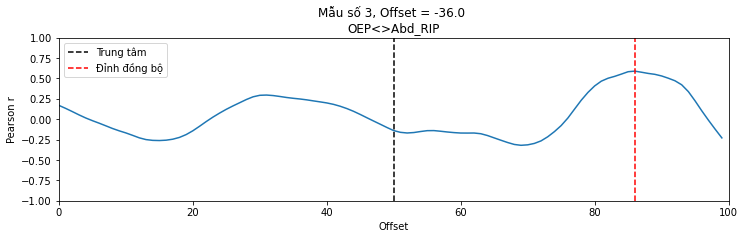

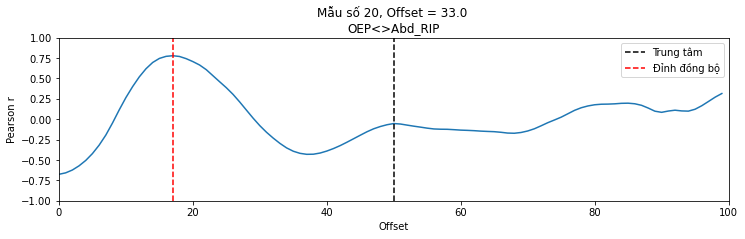

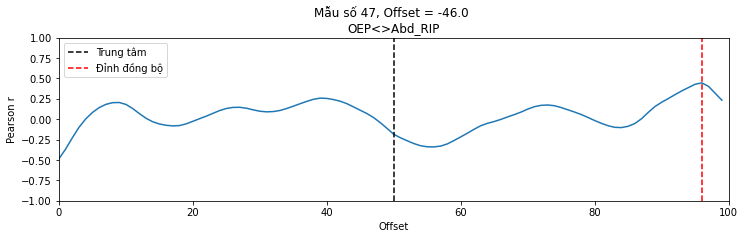

In [6]:
for s_idx in [0,3,20,47]:
    _ = lag_cross_corr(comb_df, 
                       sample_idx = s_idx, 
                       targ = 'Abd_RIP', 
                       max_lag = 50, 
                       plot = True)

Tương tự, ta có hàm multiple_lag_crosscorr để thi hành quy trình cho hàng loạt mẫu, sau đó ghép lại thành heatmap, thí dụ ta làm cho 36 đoạn Obstructives:

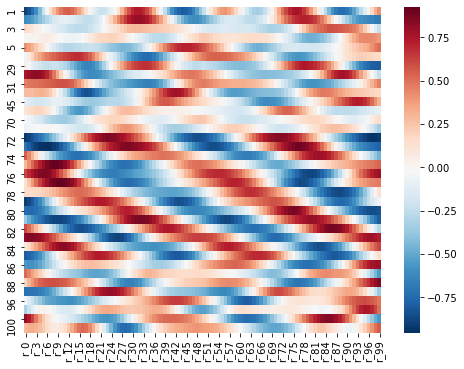

In [8]:
_ = multiple_lag_crosscorr(comb_df,
                           sampl_df,
                           targ = 'Abd_RIP',
                           evt_type = 'Obs', 
                           max_lag = 50, 
                           plot = True)

## Dynamic time warping (DTW)

Tiếp theo, Nhi sẽ áp dụng kỹ thuật DTW (quy hoạch động) để ước tính một trị số đo lường mức độ tương hợp giữa 2 chuỗi, gọi là Similarity index. Nếu 2 chuỗi hoàn toàn trùng khớp, ta có Similarity tối ưu = 0; giá trị similarity càng cao thì 2 chuỗi càng khác biệt.

Hàm DTW_similarity() sẽ ước tính giá trị Similarity cho 3 chuỗi Tx_RIP, Th_Flow, Abd_RIP khi bắt cặp với OEP, và cho tất cả 67 mẫu Cent và 36 mẫu Obs. Kết quả xuất ra trong 1 dataframe như sau:

In [9]:
sim_df = DTW_similarity(comb_df, sampl_df)

sim_df

,frag,Evt_type,Tx_RIP,Th_Flow,Abd_RIP
0,0,Cent,1.045776,1.630481,0.662845
1,1,Obs,1.547600,1.196290,1.054487
2,2,Obs,1.365981,1.489845,1.313254
3,3,Obs,1.384452,1.778200,1.456051
4,4,Obs,1.546604,1.601170,1.176640
...,...,...,...,...,...
98,98,Cent,0.926018,1.549631,1.609429
99,99,Cent,1.464236,1.454034,1.305707
100,100,Obs,2.230548,1.960914,1.566792
101,101,Obs,1.872074,1.915980,1.149125


Bước tiếp theo, ta có thể dùng 1 kiểm định thống kê, thí dụ Friedman test để so sánh giá trị Similarity giữa 3 kênh tín hiệu Tx_RIP, Th_Flow và Abd_RIP, đồng thời xác định kênh nào có Similarity thấp nhất (gần 0 nhất).

Ta chỉ phân tích cho 36 chuỗi Obstructives:

Nhi dùng class Friedman để tạo ra 1 case phân tích:

In [11]:
obs_df = sim_df[sim_df['Evt_type'] == 'Obs']

case = Friedman(df = obs_df[['Tx_RIP', 'Th_Flow', 'Abd_RIP']], 
                df_format = 'wide', 
                subj='frag',
                cond= ['Tx_RIP', 'Th_Flow', 'Abd_RIP'],
                var_name = 'Channel',
                target='Sim')

case

D:\Project\module1\association_analysis.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[subj] = df.index


Kiểm định Friedman với k=3, n=36

Thống kê mô tả cho thấy kênh Abd_RIP có trung vị Similarity thấp nhất = 1.59, khác biệt rõ với 2 kênh còn lại:

In [12]:
obs_df.describe(percentiles = [0.05,0.95])

,Tx_RIP,Th_Flow,Abd_RIP
count,36.000000,36.000000,36.000000
mean,1.786867,1.834335,1.689154
std,0.400103,0.386875,0.453376
min,1.149129,1.128080,0.912534
5%,1.221948,1.332176,1.125466
50%,1.745663,1.755444,1.588220
95%,2.353640,2.653860,2.453200
max,2.418437,2.752691,2.611925


Đặc tính phân bố giá trị Similarity giữa 3 kênh:

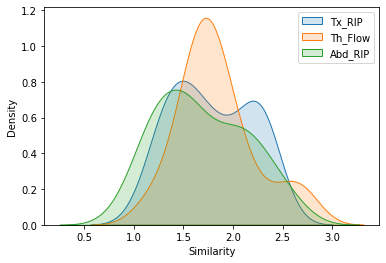

In [6]:
for i in ['Tx_RIP', 'Th_Flow', 'Abd_RIP']:
    sns.kdeplot(sim_df[sim_df['Evt_type'] == 'Obs'][i], shade = True, alpha = 0.2, label = i)
plt.legend()
plt.xlabel('Similarity')
plt.show()

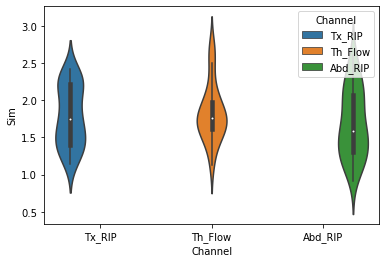

In [7]:
sns.violinplot(data = case.ldf, 
               x = 'Channel', 
               y = 'Sim', 
               hue = 'Channel')
plt.show()

F test cho thấy có sự khác biệt ý nghĩa về Similarity index giữa 3 kênh:

In [13]:
case.F_test()

,F,Độ tự do,Giá trị p,Phủ định H0
Friedman xấp xỉ,8.166667,2,0.016851,Có thể
Friedman chính xác,8.166667,2,0.016851,Có thể
Iman-Davenport,4.477807,"(2,70)",0.014792,Có thể


Post_hoc test Conover cho thấy có sự khác biệt ý nghĩa giữa similarity index của Abd_RIP và của Th_flow

In [14]:
case.Conover_test()

,Tx_RIP,Th_Flow,Abd_RIP
Tx_RIP,1.000000,0.877471,0.244373
Th_Flow,0.877471,1.000000,0.018290
Abd_RIP,0.244373,0.018290,1.000000


Hàm plot_DWT_matrix trình bày ma trận DTW giữa 1 chuỗi mục tiêu và 1 chuỗi OEP, ta khảo sát tượng trưng cho 10 cặp có Similarity index cao nhất cho kênh Abd_RIP như sau:

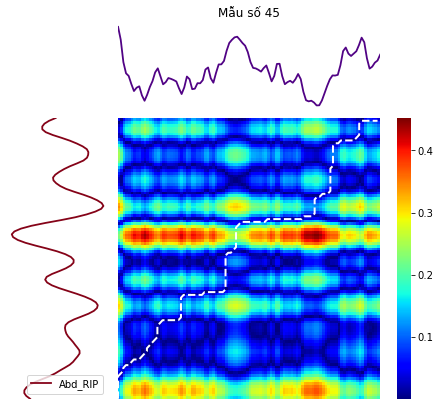

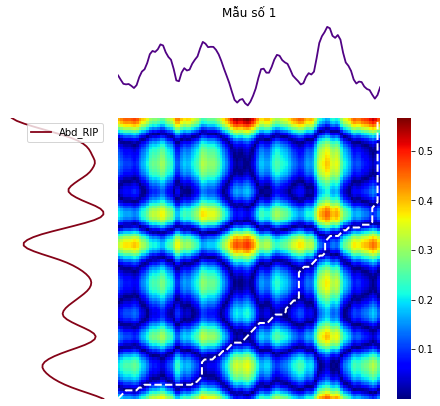

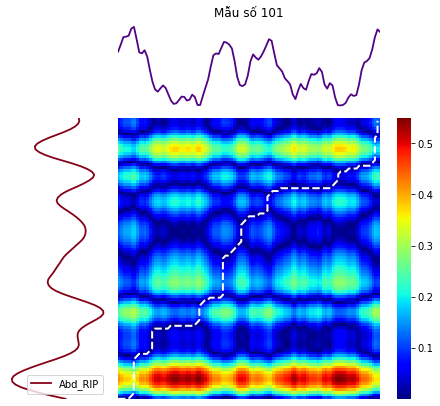

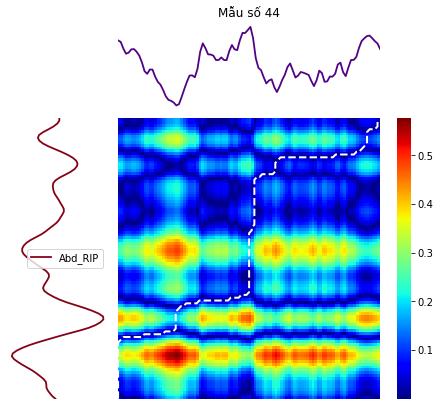

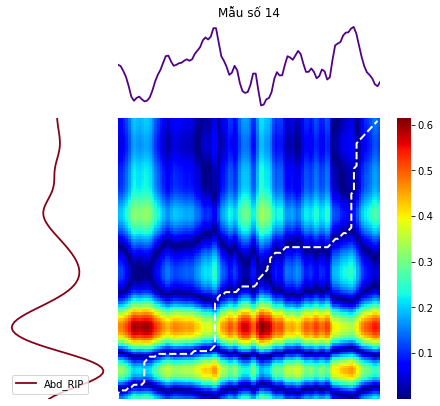

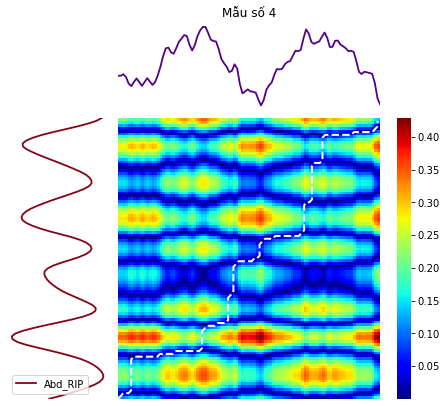

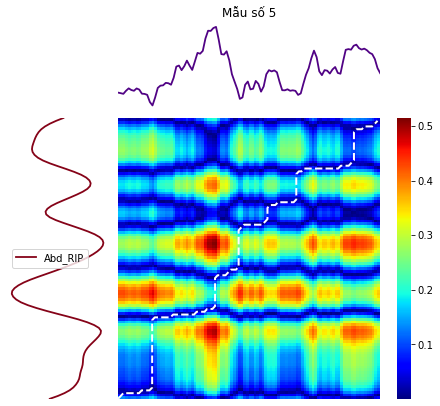

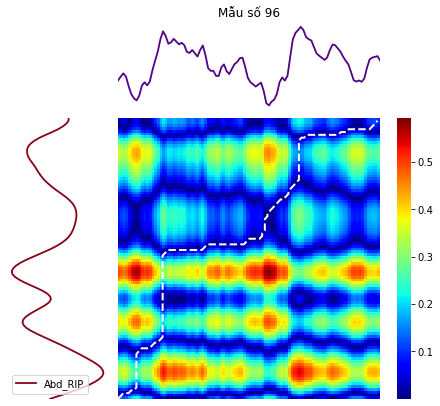

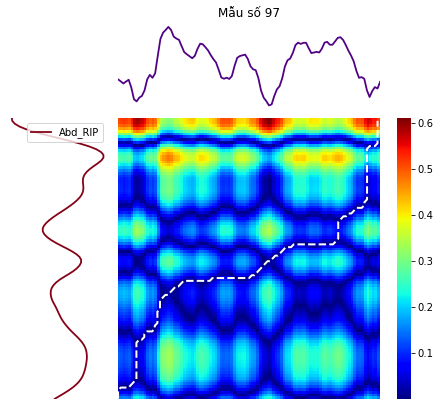

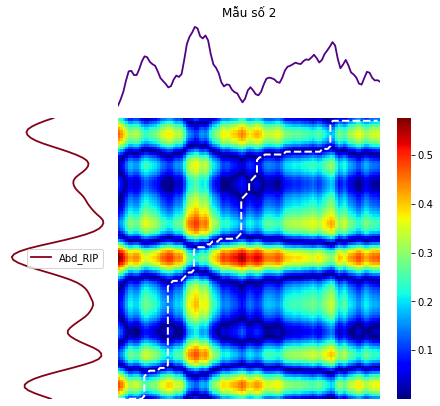

In [6]:
for s_idx in obs_df.sort_values('Abd_RIP')['frag'][:10]:
    plot_DWT_matrix(comb_df, 
                targ = 'Abd_RIP', 
                sample_idx = s_idx)

# Tổng kết

Bài thực hành đến đây khép lại, chúng ta vừa thực hiện một nghiên cứu mô tả/diễn dịch trên đối tượng là tín hiệu sinh học. Tuy đây chỉ là một thí dụ đã được giản lược (trên thực tế ta cần nhiều dữ liệu hơn, trên nhiều bệnh nhân), nhưng thông điệp chính của bài đó là các bạn có thể xây dựng nên những đề tài nghiên cứu mới lạ, thú vị khi khai thác tín hiệu sinh học - một nguồn dữ liệu rộng lớn và ít tốn kém. Khi làm nghiên cứu theo hướng này, chúng ta đang quay trở về cội nguồn của ngành Sinh lý học cơ sở, như các vị tổ phụ của ngành Y đã từng thực hiện.